In [138]:
from typing import List
import pandas as pd
from langchain.messages import AIMessage
from langchain.tools import tool
from langchain_ollama import ChatOllama
import sys, os, glob, json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sys.path.append(os.path.abspath("../"))
from pathlib import Path
from utils.metrics import evaluate_summary,calculate_bert_score,calculate_rouge_score

In [139]:

DATA_PATH: str = "../data"
PARSED_PATH: str = f"{DATA_PATH}/raw/parsed_sections"
ABSTRACT_PATH: str = f"{DATA_PATH}/raw/abstracts"
SUMMARIES_PATH: str = f"{DATA_PATH}/summaries"


# creates txt files of summaries including subfolders for sections
DEBUG: bool = True

Path(SUMMARIES_PATH).mkdir(exist_ok=True)


content_files = Path(PARSED_PATH).glob("*.json")
abstract_files = Path(ABSTRACT_PATH).glob("*.txt")
abstract_content_mapping = {}

for file in content_files:
    paper_id = file.stem
    with open(file, "r", encoding="utf-8") as json_file:
        abstract_content_mapping[paper_id] = {}
        abstract_content_mapping[paper_id]["content"] = json.load(json_file)

for file in abstract_files:
    paper_id = file.stem
    with open(file, "r", encoding="utf-8") as txt_file:
        try:
            abstract_content_mapping[paper_id]["abstract"] = ' '.join(txt_file.readlines())
            print(f"Read {file}")
        except Exception as e:
            pass
        
abstract_content_mapping

Read ../data/raw/abstracts/2510.25732v1.txt
Read ../data/raw/abstracts/2510.25612v1.txt
Read ../data/raw/abstracts/2510.25729v1.txt
Read ../data/raw/abstracts/2510.25634v1.txt
Read ../data/raw/abstracts/2510.25065v1.txt
Read ../data/raw/abstracts/2510.25668v1.txt
Read ../data/raw/abstracts/2510.25205v1.txt
Read ../data/raw/abstracts/2510.25590v1.txt
Read ../data/raw/abstracts/2510.25223v1.txt
Read ../data/raw/abstracts/2510.25517v1.txt
Read ../data/raw/abstracts/2510.25616v1.txt
Read ../data/raw/abstracts/2510.25005v1.txt
Read ../data/raw/abstracts/2510.25731v1.txt
Read ../data/raw/abstracts/2510.25595v1.txt
Read ../data/raw/abstracts/2510.25101v1.txt
Read ../data/raw/abstracts/2510.25694v1.txt
Read ../data/raw/abstracts/2510.25510v1.txt
Read ../data/raw/abstracts/2510.25179v1.txt
Read ../data/raw/abstracts/2510.25320v1.txt
Read ../data/raw/abstracts/2510.25557v1.txt
Read ../data/raw/abstracts/2510.25007v1.txt
Read ../data/raw/abstracts/2510.25577v1.txt
Read ../data/raw/abstracts/2510.

{'2510.25320v1': {'content': [{'title': '1 Introduction',
    'paragraphs': 'Recent advances in large language model (LLM)-based autonomous agents have demonstrated remarkable capabilities in complex problem-solving tasks [ 1 , 2 , 3 , 4 , 5 , 6 ] , ranging from scientific research and code generation to interactive web navigation and data analysis. A key enabler of these capabilities is tool-augmented reasoning, where agents leverage external tools such as search engines, calculators, code interpreters, and APIs to extend their problem-solving capacity beyond the inherent limitations of parametric knowledge.\nCurrent approaches to tool-augmented reasoning can be broadly categorized into two paradigms: multi-agent systems (MAS) and tool-integrated reasoning (TIR) models. Multi-agent frameworks orchestrate multiple specialized agents with distinct roles and tool sets to collaboratively solve complex tasks. These systems have shown impressive performance on benchmarks requiring sophistic

In [140]:
llm = ChatOllama(
    model="gemma3:1b",
    temperature=0,
)

In [146]:
def summarize_subsection_with_llm(title: str, text: str, debug_path: Path, child_summaries: str = ""):

    system_prompt = (
        "You are a helpful assistant that summarizes scientific paper sections.\n"
        "Produce a concise, factual summary.\n"
        "Do NOT add commentary, disclaimers, or phrases like 'The summary is:'.\n"
        "Only output the summary text itself."
    )

    user_text = f"Section title: {title}\n\nSection content:\n{text}"

    if child_summaries.strip():
        user_text += (
            "\n\nSummaries of direct subsections (for additional context):\n"
            f"{child_summaries}"
        )

    messages = [
        ("system", system_prompt),
        ("human", user_text),
    ]

    if DEBUG:
        debug_path.mkdir(parents=True, exist_ok=True)
        with open(debug_path / "prompt.txt", "w") as f:
            f.write(user_text)

    response = llm.invoke(messages).content
    return response


def summarize_section_recursive(section: dict, debug_path: Path) -> str:

    if DEBUG:
        debug_path.mkdir(parents=True, exist_ok=True)

    # Collect child summaries
    children_summary_text = ""
    for subsection in section.get("subsections", []):
        
        # ✅ FIXED: use subsection title, not parent title
        debug_path_subsection = debug_path / subsection['title'].replace("/", "_")
        
        child_text = summarize_section_recursive(
            subsection,
            debug_path=debug_path_subsection,
        )

        children_summary_text += f"- {subsection['title']}: {child_text}\n"

    # Summarize this section
    section_summary = summarize_subsection_with_llm(
        title=section["title"],
        text=section["paragraphs"],
        debug_path=debug_path,
        child_summaries=children_summary_text,
    )

    if DEBUG:
        with open(debug_path / "subsection_summary.txt", "w") as f:
            f.write(section_summary)

    return section_summary


def summarize_whole_paper(paper_title: str, paper: list) -> str:

    paper_path = Path(SUMMARIES_PATH) / paper_title
    paper_path.mkdir(parents=True, exist_ok=True)

    combined_text = ""

    for section in paper:
        debug_path_subsection = paper_path / section['title'].replace("/", "_")
        print(debug_path_subsection)

        section_summary = summarize_section_recursive(
            section,
            debug_path=debug_path_subsection,
        )

        combined_text += f"{section['title']}: {section_summary}\n"

    print(combined_text)

    final_summary = summarize_subsection_with_llm(
        title=paper_title,
        text=combined_text,
        debug_path=paper_path
    )

    with open(paper_path / "summary.txt", "w") as f:
        f.write(final_summary)

    return final_summary


In [148]:
scoring_results = []

for paper_id, mapping in tqdm(list(abstract_content_mapping.items())):
    subsection_llm_summary =  summarize_whole_paper(paper_id,mapping["content"])#get_lead_N(content=mapping["content"], n=5)
    
    mapping["SUBSECTIION_LLM"] = subsection_llm_summary

    # SUBSECTIION_LLM
    rouge_scores_subsection_llm = calculate_rouge_score(mapping["abstract"], mapping["SUBSECTIION_LLM"])
    bert_scores_subsection_llm = calculate_bert_score(mapping["abstract"], mapping["SUBSECTIION_LLM"])



    scoring_results.append(
        {
            "paper_id": paper_id, 
            "method": "SUBSECTIION_LLM",
            "rouge1": rouge_scores_subsection_llm["rouge1_fmeasure"], 
            "rougeL": rouge_scores_subsection_llm["rougeL_fmeasure"],
            "bert_score_f1": bert_scores_subsection_llm["bertscore_f1"]
        }
    )


  0%|          | 0/40 [00:00<?, ?it/s]

../data/summaries/2510.25320v1/1 Introduction
../data/summaries/2510.25320v1/2 Background
../data/summaries/2510.25320v1/3 Graph-based Agent Planning Paradigm
../data/summaries/2510.25320v1/4 Training Pipeline
../data/summaries/2510.25320v1/5 Experiments
../data/summaries/2510.25320v1/6 Conclusion
../data/summaries/2510.25320v1/References
../data/summaries/2510.25320v1/Appendix A Related Work
../data/summaries/2510.25320v1/Appendix B Case Study
1 Introduction: Graph-based agent planning enables parallel and serial tool execution through explicit task dependency modeling, improving agent efficiency and generalization.
2 Background: The paper introduces the ReAct-style approach, leveraging few-shot exemplars to guide an LLM through a “Thought-Action-Observation” cycle, interleaving reasoning traces, tool use, and observation. Tool-Integrated Reasoning (TIR) enhances LLMs’ code reasoning by integrating natural language with external tool execution environments, maintaining a global state 

  2%|▎         | 1/40 [00:42<27:24, 42.18s/it]

../data/summaries/2510.25232v1/1 Introduction
../data/summaries/2510.25232v1/2 Related Work
../data/summaries/2510.25232v1/3 Patient EMR and Experience Generation Workflow
../data/summaries/2510.25232v1/4 Multi-agent Diagnosis Framework
../data/summaries/2510.25232v1/5 Final Product: PsyCoTalk Dataset
../data/summaries/2510.25232v1/Limitations
../data/summaries/2510.25232v1/6 Conclusion
../data/summaries/2510.25232v1/Ethics Statement
../data/summaries/2510.25232v1/References
../data/summaries/2510.25232v1/Appendix A Appendix
1 Introduction: PsyCoTalk is a large-scale dialogue dataset designed for comorbidity diagnosis, utilizing synthetic social media posts transformed into structured EMRs to train a three-agent diagnostic system. It includes 502 synthetic EMRs representing common comorbid conditions and provides a clinically grounded multi-agent framework combining a Hierarchical Diagnostic State Machine (HDSM) and Diagnosis Context Tree (DCT) for comprehensive diagnostic reasoning.
2

  5%|▌         | 2/40 [01:29<28:42, 45.33s/it]

../data/summaries/2510.25563v1/1 Introduction
../data/summaries/2510.25563v1/2 Related Work
../data/summaries/2510.25563v1/3 Dataset and Study Area
../data/summaries/2510.25563v1/4 A Foundational Model for Forecasting the SST
../data/summaries/2510.25563v1/5 Experimental Configuration
../data/summaries/2510.25563v1/6 Results
../data/summaries/2510.25563v1/7 Discussion
../data/summaries/2510.25563v1/8 Conclusion
../data/summaries/2510.25563v1/References
1 Introduction: This work adapts the Aurora model, initially developed for global atmospheric applications, to subregional ocean prediction, focusing on the Canary Upwelling System. Utilizing data from the GLORYS12V1 ocean prediction system, the model predicts the evolution of SST, salinity, currents, and two-dimensional variables, offering improved computational cost reduction and prediction quality, though limitations remain due to domain complexity.
2 Related Work: Deep learning has significantly advanced oceanographic and climate pre

  8%|▊         | 3/40 [02:04<24:54, 40.38s/it]

../data/summaries/2510.25590v1/1 Introduction
../data/summaries/2510.25590v1/2 Related Work
../data/summaries/2510.25590v1/3 Preliminary
../data/summaries/2510.25590v1/4 Methodology
../data/summaries/2510.25590v1/5 Experiment
../data/summaries/2510.25590v1/6 Conclusion
../data/summaries/2510.25590v1/References
../data/summaries/2510.25590v1/Appendix A Pseudocode of RegionE
../data/summaries/2510.25590v1/Appendix B Analysis of Adaptive Velocity Decay Cache
../data/summaries/2510.25590v1/Appendix C Per-Task Visualization Results in the Benchmark
../data/summaries/2510.25590v1/Appendix D Per-Task Quantitative Results in the Benchmark
1 Introduction: RegionE introduces a training-free framework that reduces spatial and temporal redundancy in IIE models through adaptive region-aware generation and a velocity-decay cache. Experimental results demonstrate significant speedups on Step1X-Edit, FLUX.1 Kontext, and Qwen-Image-Edit, while maintaining PSNR values of 30.520, 32.133, and 31.115, and 

 10%|█         | 4/40 [02:28<20:29, 34.16s/it]

../data/summaries/2510.25007v1/1 Introduction
../data/summaries/2510.25007v1/2 Related Work
../data/summaries/2510.25007v1/3 Task Overview
../data/summaries/2510.25007v1/4 The ProFees Model
../data/summaries/2510.25007v1/5 Data Gathering and Annotation
../data/summaries/2510.25007v1/6 Evaluation and Results
../data/summaries/2510.25007v1/7 Conclusion and Future Work
../data/summaries/2510.25007v1/Limitations
../data/summaries/2510.25007v1/Ethical Considerations
../data/summaries/2510.25007v1/Acknowledgement
../data/summaries/2510.25007v1/References
../data/summaries/2510.25007v1/Appendix A MDM Guidelines
../data/summaries/2510.25007v1/Appendix B Ablation Studies
../data/summaries/2510.25007v1/Appendix C High-Level Prompt Templates for CPT E_M Components
../data/summaries/2510.25007v1/Appendix D Datasets
../data/summaries/2510.25007v1/Appendix E Additional Experiments
../data/summaries/2510.25007v1/Appendix F Synthetic Example
1 Introduction: ProFees is an automated CPT E/M coding model

 12%|█▎        | 5/40 [03:17<23:04, 39.56s/it]

../data/summaries/2510.25388v1/1 Introduction
../data/summaries/2510.25388v1/2 Foundations of automatic abstractions
../data/summaries/2510.25388v1/3 Method
../data/summaries/2510.25388v1/4 Experiment setup
../data/summaries/2510.25388v1/5 Experiments
../data/summaries/2510.25388v1/6 Conclusion, Limitations and Future Work
../data/summaries/2510.25388v1/References
../data/summaries/2510.25388v1/Appendix A Supplementary Materials
1 Introduction: Research into non-learning-based decision-making algorithms, such as Monte Carlo Tree Search (MCTS), is an active field. MCTS can be used for applications where a general on-the-fly decision-making algorithm is needed, such as Game Studios which rarely use Machine Learning (ML) based AI as they would have to be retrained whenever the game rules are modified (e.g. during development or patches). One way to improve MCTS is to reduce the search space by grouping states and actions in the current MCTS search tree to enable intra-layer information fl

 15%|█▌        | 6/40 [04:11<25:11, 44.46s/it]

../data/summaries/2510.25770v1/1 INTRODUCTION
../data/summaries/2510.25770v1/2 PROBLEM FORMULATION
../data/summaries/2510.25770v1/3 BACKGROUND AND RELATED WORK
../data/summaries/2510.25770v1/4 E-SCORES
../data/summaries/2510.25770v1/5 EXPERIMENTAL RESULTS
../data/summaries/2510.25770v1/6 THEORETICAL RESULTS
../data/summaries/2510.25770v1/7 CONCLUSIONS
../data/summaries/2510.25770v1/Appendix A THEORETICAL RESULTS
../data/summaries/2510.25770v1/Appendix B EXPERIMENTAL RESULTS
../data/summaries/2510.25770v1/Appendix C IMPLICIT P-SCORES IN RELATED WORKS
1 INTRODUCTION: Here’s a summary of the paper’s sections:

Introduction: Generative models, like LLMs, are prone to errors, requiring careful assessment. The example illustrates a failure of the LLM in a math problem, prompting research into post-hoc error assessment. This work proposes e-scores as a data-dependent measure of incorrectness, addressing the limitations of p-value-based conformal prediction.

Section 2: Background and Related 

 18%|█▊        | 7/40 [05:16<28:01, 50.96s/it]

../data/summaries/2510.25662v1/1. Introduction
../data/summaries/2510.25662v1/2. Related Work
../data/summaries/2510.25662v1/3. Research Method
../data/summaries/2510.25662v1/4. Misconceptions Brainstorming
../data/summaries/2510.25662v1/5. Qualitative Analysis of Conversational Logs
../data/summaries/2510.25662v1/6. Results
../data/summaries/2510.25662v1/7. Discussion
../data/summaries/2510.25662v1/8. Limitations
../data/summaries/2510.25662v1/9. Conclusions
../data/summaries/2510.25662v1/References
1. Introduction: This study investigates user misconceptions about conversational LLM-based programming tools, focusing on features like web access, model knowledge, and runtime limitations. Analysis of 500 Python conversations reveals misconceptions regarding these aspects, particularly during debugging and when prompting for code generation. The research aims to inform design choices to improve user understanding of these tools’ capabilities.
2. Related Work: Related work explores the te

 20%|██        | 8/40 [06:21<29:38, 55.57s/it]

../data/summaries/2510.25729v1/I Introduction
../data/summaries/2510.25729v1/II Methodology
../data/summaries/2510.25729v1/III Results
../data/summaries/2510.25729v1/IV Conclusion
../data/summaries/2510.25729v1/V Acknowledgment
../data/summaries/2510.25729v1/References
I Introduction: Diffusion-based generative model demonstrates improved reconstruction accuracy and stability compared to deterministic supervised networks, particularly in challenging scenarios involving noise and calibration errors. The physics-informed validation ensures physically consistent solutions, enhancing robustness and generalization to real-world MWI data.
II Methodology: Diffusion models approximate a target distribution by iteratively adding noise and removing it. Sampling involves denoising back to a clean sample, utilizing a neural network to approximate the score function. The model’s flexibility makes it suitable for inverse problems, leveraging a Bayesian framework to sample from a posterior distributi

 22%|██▎       | 9/40 [07:09<27:24, 53.05s/it]

../data/summaries/2510.25005v1/1 Introduction
../data/summaries/2510.25005v1/2 Background and Problem Setup
../data/summaries/2510.25005v1/3 Theory
../data/summaries/2510.25005v1/4 Example
../data/summaries/2510.25005v1/5 Limitations
../data/summaries/2510.25005v1/6  Conclusion and Future Work
../data/summaries/2510.25005v1/Acknowledgments and Disclosure of Funding
../data/summaries/2510.25005v1/References
../data/summaries/2510.25005v1/Appendix A Supplementary Material
../data/summaries/2510.25005v1/References
1 Introduction: This work introduces a theoretical framework for counterfactual reasoning in cyclic causal models, utilizing shift-scale interventions. It demonstrates the uniqueness of simple cyclic models under contraction conditions, proves the well-posedness of counterfactual queries under bounded scale interventions, establishes compositionality and algebraic stability, and derives sub-Gaussian tail bounds for counterfactual functionals, emphasizing sharp concentration of o

 25%|██▌       | 10/40 [07:47<24:18, 48.63s/it]

../data/summaries/2510.25758v1/1 Introduction
../data/summaries/2510.25758v1/2 Related Work
../data/summaries/2510.25758v1/3 Methodology
../data/summaries/2510.25758v1/4 Experiments
../data/summaries/2510.25758v1/5 Conclusion
../data/summaries/2510.25758v1/References
../data/summaries/2510.25758v1/Appendix A Human Evaluation of Pairwise Response Selection
../data/summaries/2510.25758v1/Appendix B Human Agreement Analysis
../data/summaries/2510.25758v1/Appendix C Ethical Considerations
../data/summaries/2510.25758v1/Appendix D Open-source Models
../data/summaries/2510.25758v1/Appendix E Expert Evaluation
../data/summaries/2510.25758v1/Appendix F Prompts for TheraMind
../data/summaries/2510.25758v1/Appendix G TheraMind of Counseling Strategies
1 Introduction: TheraMind introduces a dual-loop agent architecture for longitudinal psychological counseling, demonstrating improved efficacy through adaptive therapy selection and a novel dialogue management system. The agent’s architecture facil

 28%|██▊       | 11/40 [08:33<23:05, 47.77s/it]

../data/summaries/2510.25445v1/1 Introduction
../data/summaries/2510.25445v1/2 Theoretical Foundations: Mapping the Dual Lineages of Agentic Intelligence
../data/summaries/2510.25445v1/3 Methodology
../data/summaries/2510.25445v1/4 Literature Review: A Dual-Paradigm Analysis
../data/summaries/2510.25445v1/5 Analysis of Domain-Specific Applications
../data/summaries/2510.25445v1/6 Comprehensive Taxonomy of Agentic AI Literature: A Paradigm-Aware Analysis
../data/summaries/2510.25445v1/7 Ethical and Governance Challenges: A Paradigm-Specific Analysis
../data/summaries/2510.25445v1/8 Research Gaps: A Paradigm-Specific Roadmap
../data/summaries/2510.25445v1/9 Future Directions: The Path to Hybrid Intelligence
../data/summaries/2510.25445v1/10 Conclusion
../data/summaries/2510.25445v1/References
1 Introduction: The paper reviews the evolution of Artificial Intelligence, starting with the foundational concept of autonomous systems, then transitioning through symbolic AI, machine learning, de

 30%|███       | 12/40 [09:36<24:24, 52.30s/it]

../data/summaries/2510.25683v1/1 Introduction
../data/summaries/2510.25683v1/2 Methods
../data/summaries/2510.25683v1/3 Case Study and Results
../data/summaries/2510.25683v1/4 Conclusions
../data/summaries/2510.25683v1/References
1 Introduction: Graph Network-based Structural Simulator (GNSS) introduces a GNN framework for surrogate modeling of structural dynamics, particularly for guided wave simulations. It combines node-fixed nodal kinematics, a sign-aware acceleration loss, and a wavelength-informed connectivity radius to stabilize finite-difference velocities and improve long-horizon stability. The paper demonstrates GNSS’s effectiveness on wave propagation in a clamped beam, achieving superior performance compared to traditional GNN methods based on absolute nodal positions, through the preservation of locality and mitigation of failure modes.
2 Methods: Okay, that’s fantastic feedback! Thank you. Let’s focus on the primary goal – simulating a physical system, specifically a simp

 32%|███▎      | 13/40 [10:28<23:32, 52.33s/it]

../data/summaries/2510.25557v1/1 Introduction
../data/summaries/2510.25557v1/2 Related Work
../data/summaries/2510.25557v1/3 Model
../data/summaries/2510.25557v1/4 Experiments
../data/summaries/2510.25557v1/5 Discussion and Conclusion
../data/summaries/2510.25557v1/Appendix A Quantum States and Superposition
../data/summaries/2510.25557v1/Appendix B PQC Template
../data/summaries/2510.25557v1/Appendix C Experimental Settings and Test Accuracy Statistics Across Runs
../data/summaries/2510.25557v1/Appendix D Attention Alignments
../data/summaries/2510.25557v1/References
1 Introduction: This work presents a hybrid quantum-classical recurrent neural network (QRNN) architecture. The QRNN utilizes a PQC, a quantum state representing the recurrent core, which evolves through unitary transformations, preserving gradients and memory across timesteps. The hidden state is a quantum state, allowing for exponential memory capacity and representing the model’s core recurrent memory. The model’s perf

 35%|███▌      | 14/40 [11:17<22:08, 51.08s/it]

../data/summaries/2510.25510v1/1 Introduction
../data/summaries/2510.25510v1/2 Related Work
../data/summaries/2510.25510v1/3 Methodology
../data/summaries/2510.25510v1/4 Experiments
../data/summaries/2510.25510v1/5 conclusion
../data/summaries/2510.25510v1/References
../data/summaries/2510.25510v1/Appendix A Use of LLMs
../data/summaries/2510.25510v1/Appendix B LLM Response Rollout with Multi-Turn Sql Excursions Calls
../data/summaries/2510.25510v1/Appendix C Prompt and Case Study
1 Introduction: MTIR-SQL is a reinforcement learning framework for Multi-turn Tool-Integrated Reasoning in Text-to-SQL. It enhances LLMs' reasoning through trajectory filtering and KL regularization, enabling interactive, iterative execution verification and improved SQL execution accuracy. Experiments on the BIRD dataset demonstrate its effectiveness, achieving a 16% absolute improvement over baselines.
2 Related Work: The paper reviews existing work on Tool-Integrated Reasoning (TIR), highlighting challenge

 38%|███▊      | 15/40 [11:53<19:27, 46.70s/it]

../data/summaries/2510.25588v1/1 Introduction
../data/summaries/2510.25588v1/2 Background
../data/summaries/2510.25588v1/3 System Architecture
../data/summaries/2510.25588v1/4 Platform Functionality
../data/summaries/2510.25588v1/5 Implementation and Evaluation
../data/summaries/2510.25588v1/6 Related Work
../data/summaries/2510.25588v1/7 Conclusions and Future Work
../data/summaries/2510.25588v1/Acknowledgements
../data/summaries/2510.25588v1/References
../data/summaries/2510.25588v1/Authors
1 Introduction: This research introduces a novel AI-assisted diagnostic platform leveraging fine-tuned LLMs, the OpenAI-gpt-oss reasoning model, and an orchestration LLM to improve the accuracy and consistency of mental disorder diagnoses. The system analyzes conversational data to predict diagnoses, utilizes a consortium of LLMs for final decision-making, and incorporates responsible AI principles through a dedicated orchestration agent. The prototype is deployed in collaboration with the U.S. Ar

 40%|████      | 16/40 [12:51<20:00, 50.01s/it]

../data/summaries/2510.25101v1/1 Introduction
../data/summaries/2510.25101v1/2 Related Work
../data/summaries/2510.25101v1/3 Preliminaries
../data/summaries/2510.25101v1/4 Methodology
../data/summaries/2510.25101v1/5 Experiments
../data/summaries/2510.25101v1/6 Conclusion
../data/summaries/2510.25101v1/References
../data/summaries/2510.25101v1/7 Appendices
../data/summaries/2510.25101v1/Appendix A Experiment Setup
../data/summaries/2510.25101v1/Appendix B Further Analysis
../data/summaries/2510.25101v1/Appendix C Statistics
../data/summaries/2510.25101v1/Appendix D Error Analysis
../data/summaries/2510.25101v1/Appendix E Prompts
../data/summaries/2510.25101v1/Appendix F Case Study
1 Introduction: KnowCoder-A1 is an agentic reasoning model for Knowledge Base Question Answering, designed to autonomously decompose tasks, utilize tools, and refine queries. It leverages outcome supervision through a multi-stage curriculum reinforcement learning approach, improving robustness and flexibility

 42%|████▎     | 17/40 [13:43<19:26, 50.72s/it]

../data/summaries/2510.25577v1/1.  Introduction
../data/summaries/2510.25577v1/2.  Method
../data/summaries/2510.25577v1/3.  Experiments
../data/summaries/2510.25577v1/4.  Results
../data/summaries/2510.25577v1/5.  Discussion
../data/summaries/2510.25577v1/6.  Conclusion
../data/summaries/2510.25577v1/7.  Bibliographical References
../data/summaries/2510.25577v1
../data/summaries/2510.25577v1/8.  Language Resource References
../data/summaries/2510.25577v1
../data/summaries/2510.25577v1/Appendix A Appendix: Model Bias Evaluation Dimensions
../data/summaries/2510.25577v1/Appendix B Appendix: Speech Emotion Recognition Results
1.  Introduction: VQ-Bench is a framework for evaluating speech models' sensitivity to voice quality variation. It presents parallel prompts in various phonation types, used to evaluate long-form and speech emotion recognition. The study aims to systematically study SFM behavior under controlled variation, create synthetic voice quality data, and provide an open-end

 45%|████▌     | 18/40 [14:13<16:17, 44.44s/it]

../data/summaries/2510.25091v1/1. Introduction
../data/summaries/2510.25091v1/2. Related Work
../data/summaries/2510.25091v1/3. Methodology
../data/summaries/2510.25091v1/4. Experiment
../data/summaries/2510.25091v1/5. Conclusion
../data/summaries/2510.25091v1/References
../data/summaries/2510.25091v1/Appendix A Problem Definition
../data/summaries/2510.25091v1/Appendix B Global Context Hypergraph (GCH)
../data/summaries/2510.25091v1/Appendix C Expert Routing and Aggregation
../data/summaries/2510.25091v1/Appendix D Experiment Settings
../data/summaries/2510.25091v1/Appendix E Baseline Descriptions
../data/summaries/2510.25091v1/Appendix F Metric Definitions
../data/summaries/2510.25091v1/Appendix G Backtesting Setting
1. Introduction: Here’s a summary of the paper:

The paper explores novel architectures for predicting stock market movements, addressing challenges posed by complex market dynamics and the increasing influence of textual data. It proposes a multi-modal architecture inte

 48%|████▊     | 19/40 [15:23<18:12, 52.03s/it]

../data/summaries/2510.25518v1/I Introduction
../data/summaries/2510.25518v1/II Related Work
../data/summaries/2510.25518v1/III Agent Design
../data/summaries/2510.25518v1/IV Data and Evaluation Strategy
../data/summaries/2510.25518v1/V Experiments and Results
../data/summaries/2510.25518v1/VI Discussion
../data/summaries/2510.25518v1/VII Conclusion and Future Work
../data/summaries/2510.25518v1/References
I Introduction: The paper introduces an agent-based RAG system designed for fintech domain retrieval, addressing challenges of acronym resolution, contextual understanding, and evaluation within complex, regulated environments. It proposes an Orchestrator Agent, specialized sub-agents for acronym handling, query rewriting, and re-ranking, alongside a semi-automated evaluation strategy utilizing LLM-as-a-judge and internal knowledge bases. The system aims to improve retrieval accuracy and answer relevance through a modular architecture and a focused evaluation methodology.
II Related 

 50%|█████     | 20/40 [16:06<16:31, 49.56s/it]

../data/summaries/2510.24832v1/1 Introduction
../data/summaries/2510.24832v1/2 Related Work
../data/summaries/2510.24832v1/3 Preliminaries
../data/summaries/2510.24832v1/4 Motivation
../data/summaries/2510.24832v1/5 Method
../data/summaries/2510.24832v1/6 Analysis
../data/summaries/2510.24832v1/7 Experiment
../data/summaries/2510.24832v1/8 Conclusions
../data/summaries/2510.24832v1/Ethics statement
../data/summaries/2510.24832v1/Reproducibility statement
../data/summaries/2510.24832v1/References
../data/summaries/2510.24832v1/Appendix A Usage of LLMs
../data/summaries/2510.24832v1/Appendix B Details of Experimental Setup
../data/summaries/2510.24832v1/Appendix C Supplementary Experiment: Effect of Metric Selection
1 Introduction: The Rationale Score (r-score) quantifies a query’s learning efficiency based on its reasoning tree structure, offering a more accurate assessment of difficulty than path-based metrics. The Re-Schedule algorithm, a data scheduling method, utilizes the r-score t

 52%|█████▎    | 21/40 [16:48<14:57, 47.23s/it]

../data/summaries/2510.25504v1/1 Introduction
../data/summaries/2510.25504v1/2 Problem Setting & Variants
../data/summaries/2510.25504v1/3 Algorithmic Advances
../data/summaries/2510.25504v1/4 MOS as an Algorithmic Toolbox
../data/summaries/2510.25504v1/5 Emerging Applications
../data/summaries/2510.25504v1/6 Open Challenges and Opportunities
../data/summaries/2510.25504v1/7 Conclusion
../data/summaries/2510.25504v1/Acknowledgments
../data/summaries/2510.25504v1/References
1 Introduction: Multi-objective search is a burgeoning field with growing interest across diverse disciplines, including operations research, robotics, and machine learning. This paper presents an accessible overview of recent advances, focusing on problem variants, algorithms, and applications, while acknowledging the need for further technical detail.
2 Problem Setting & Variants: Okay, let's break down this text and summarize the key points about the paper's focus. Here's a consolidated explanation of the paper's 

 55%|█████▌    | 22/40 [17:58<16:10, 53.91s/it]

../data/summaries/2510.25731v1/1 Introduction
../data/summaries/2510.25731v1/2 Theoretical Background
../data/summaries/2510.25731v1/3 LieSolver
../data/summaries/2510.25731v1/4 Experiments and results
../data/summaries/2510.25731v1/5 Conclusion
../data/summaries/2510.25731v1/Appendix A Appendix
../data/summaries/2510.25731v1/References
1 Introduction: LieSolver aims to solve linear homogeneous PDEs using a Lie-symmetrical machine learning framework, offering a more accurate and efficient approach than PINNs by enforcing the PDE directly through a PDE-informed architecture, minimizing training time and requiring only boundary data.
2 Theoretical Background: Okay, let's break down this text and focus on understanding the core concepts presented.  It’s a foundational introduction to the theory of Lie symmetries, particularly in the context of PDEs. Here’s a breakdown of what’s being discussed, organized for clarity:

**1. The Core Idea: Lie Symmetries and PDEs**

* **PDEs (Partial Differ

 57%|█████▊    | 23/40 [19:20<17:38, 62.29s/it]

../data/summaries/2510.25668v1/1 Introduction
../data/summaries/2510.25668v1/2 Related Work
../data/summaries/2510.25668v1/3 Preliminaries
../data/summaries/2510.25668v1/4 Methodology
../data/summaries/2510.25668v1/5 Experiments
../data/summaries/2510.25668v1/6 Conclusions
../data/summaries/2510.25668v1/LLM Usage Statement
../data/summaries/2510.25668v1/Acknowledgments
../data/summaries/2510.25668v1/Reproducibility Statement
../data/summaries/2510.25668v1/References
../data/summaries/2510.25668v1/Appendix A Datasets
../data/summaries/2510.25668v1/Appendix B Baselines
../data/summaries/2510.25668v1/Appendix C Implementation Details
../data/summaries/2510.25668v1/Appendix D Evaluation Metrics
../data/summaries/2510.25668v1/Appendix E Case Study
1 Introduction: Agentic Long-Document Navigation (ALDEN) is a multi-turn reinforcement learning framework designed to train Visual Language Models (VLMs) as active agents capable of navigating and reasoning over long documents to deliver accurate 

 60%|██████    | 24/40 [20:22<16:36, 62.30s/it]

../data/summaries/2510.25626v1/1 Introduction
../data/summaries/2510.25626v1/2 Related Work
../data/summaries/2510.25626v1/3 Logic Programming and Deductive Reasoning
../data/summaries/2510.25626v1/4 Evaluating Language Models on Grade School Math Word Problems
../data/summaries/2510.25626v1/5 Experiments
../data/summaries/2510.25626v1/6 Conclusion
../data/summaries/2510.25626v1/Acknowledgments and Disclosure of Funding
../data/summaries/2510.25626v1/References
../data/summaries/2510.25626v1/Appendix A Further Background
../data/summaries/2510.25626v1/Appendix B Decidability of GSM Programs
../data/summaries/2510.25626v1/Appendix C Data Generation
../data/summaries/2510.25626v1/Appendix D More Details on Experiments
1 Introduction: This paper introduces a formalization of deductive reasoning based on logic programming, aiming to evaluate language model reasoning efficiency. It demonstrates that while LMs often generate more tokens than necessary, recent findings suggest a key dimension

 62%|██████▎   | 25/40 [25:43<34:58, 139.93s/it]

../data/summaries/2510.25014v1/Introduction
../data/summaries/2510.25014v1/Related Work
../data/summaries/2510.25014v1/Proposed Method
../data/summaries/2510.25014v1/Experiments and Results
../data/summaries/2510.25014v1/Conclusion
../data/summaries/2510.25014v1/References
../data/summaries/2510.25014v1/Appendix A Detailed Prompts for All Experimental Setups
../data/summaries/2510.25014v1/Appendix B Item Data Used in Prompts
../data/summaries/2510.25014v1/Appendix C Dialogue Examples
../data/summaries/2510.25014v1/Appendix D Additional Experimental Results
Introduction: The paper introduces Autoregressive State-Tracking Prompting (ASTP), a prompting methodology that resolves the tension between flexibility and control by requiring the LLM to infer and output the previous dialogue state’s label before predicting the next. This structured workflow, Prime–Guide–Enforce, ensures procedural compliance while maintaining conversational naturalness. The approach enhances numerical reliability 

 65%|██████▌   | 26/40 [26:28<26:00, 111.49s/it]

../data/summaries/2510.25065v1/1 Introduction
../data/summaries/2510.25065v1/2 PM4GRPO: Reasoning-Aware GRPO using Process Mining
../data/summaries/2510.25065v1/3 Experiments
../data/summaries/2510.25065v1/4 Conclusion
../data/summaries/2510.25065v1/References
1 Introduction: This paper introduces PM4GRPO, a novel reasoning-aware GRPO framework that utilizes Process Mining (PM) to evaluate reasoning quality. It extracts reasoning traces from a pretrained teacher model and uses this information to reward the student model’s self-generated reasoning process, ensuring alignment while preserving model freedom of thought. Experimental results demonstrate its effectiveness in enhancing reinforcement learning.
2 PM4GRPO: Reasoning-Aware GRPO using Process Mining: PM4GRPO introduces a conformance reward to evaluate reasoning alignment between the policy model and a pretrained teacher model, utilizing a sequence-level importance ratio and clipping at the sequence level.
3 Experiments: PM4GRPO d

 68%|██████▊   | 27/40 [26:42<17:49, 82.28s/it] 

../data/summaries/2510.25634v1/1 Introduction
../data/summaries/2510.25634v1/2 Related Work
../data/summaries/2510.25634v1/3 Method
../data/summaries/2510.25634v1/4 Experiments
../data/summaries/2510.25634v1/5 Conclusion
../data/summaries/2510.25634v1/References
1 Introduction: This paper introduces a hierarchical framework for bimanual manipulation using reinforcement learning and integrated skill planning. It proposes a Transformer-based policy that generates plans specifying discrete skills and continuous parameters, demonstrating improved success rates and efficiency compared to traditional sequential planning methods.
2 Related Work: This work explores TAMP approaches for multiple robots, addressing challenges with handcrafted models and reliance on imitation learning. It utilizes a hierarchical modeling approach, employing parameterized contact-rich primitives for bimanual manipulation, offering flexibility while benefiting from temporal abstraction.
3 Method: Here’s a concise su

 70%|███████   | 28/40 [27:10<13:11, 65.95s/it]

../data/summaries/2510.25602v1/1 Introduction
../data/summaries/2510.25602v1/2 Preliminaries
../data/summaries/2510.25602v1/3 Quantization Recipe
../data/summaries/2510.25602v1/4 Theoretical Framework
../data/summaries/2510.25602v1/5 FP v.s. INT
../data/summaries/2510.25602v1/6 Hardware Cost Analysis
../data/summaries/2510.25602v1/7 Conclusion
../data/summaries/2510.25602v1/References
../data/summaries/2510.25602v1/Outlines
../data/summaries/2510.25602v1/8 Related Work
../data/summaries/2510.25602v1/9 Proofs of Theorems
../data/summaries/2510.25602v1/10 Hardware Cost Modeling
../data/summaries/2510.25602v1/11 More Details for Reproduction
1 Introduction: This paper investigates the performance trade-offs of fine-grained INT and FP quantization, particularly in the context of large language models. It introduces a theoretical framework to model the quantization signal-to-noise ratio (QSNR) and demonstrates that MXINT8 consistently outperforms MXFP8 in both direct-cast and low-bit traini

 72%|███████▎  | 29/40 [28:23<12:27, 67.95s/it]

../data/summaries/2510.25205v1/I Introduction
../data/summaries/2510.25205v1/II Related Works
../data/summaries/2510.25205v1/III Overview
../data/summaries/2510.25205v1/IV Adaptive Perception
../data/summaries/2510.25205v1/V Robust Decision
../data/summaries/2510.25205v1/VI Experiments
../data/summaries/2510.25205v1/VII Conclusion
../data/summaries/2510.25205v1/VIII Acknowledgment
../data/summaries/2510.25205v1/References
I Introduction: This study proposes an energy-efficient autonomous driving framework, EneAD, to optimize perception and decision-making within a traffic scenario. It utilizes a lightweight classification model, tunable knobs for framerate and interpolation, and a meta-learning strategy to efficiently explore configurations. Experiments demonstrate improved energy consumption and driving performance compared to existing approaches.
II Related Works: This study examines perception and decision-making modules in autonomous driving, focusing on modular approaches compared

 75%|███████▌  | 30/40 [29:24<10:59, 65.96s/it]

../data/summaries/2510.25223v1/I Introduction
../data/summaries/2510.25223v1/II BACKGROUND & RELATED WORK
../data/summaries/2510.25223v1/III Problem Formulation
../data/summaries/2510.25223v1/IV Methodology
../data/summaries/2510.25223v1/V Experiment
../data/summaries/2510.25223v1/VI Conclusion
../data/summaries/2510.25223v1/References
I Introduction: FELA is a multi-agent collaborative system designed to automatically extract novel and insightful features from large-scale industrial event log data, addressing challenges related to complexity, explainability, and self-evolution. The system employs a hybrid evolution framework combining genetic and reinforcement learning to efficiently guide idea exploration and improve feature discovery. Experiments demonstrate the system’s effectiveness in real-world industrial scenarios, significantly reducing manual feature engineering time and enhancing predictive model performance.
II BACKGROUND & RELATED WORK: II. Background and Related Work: Fea

 78%|███████▊  | 31/40 [30:29<09:51, 65.71s/it]

../data/summaries/2510.25179v1/I Introduction
../data/summaries/2510.25179v1/II Literature Review and Background
../data/summaries/2510.25179v1/III Methodology
../data/summaries/2510.25179v1/IV Experiments Setup and Results
../data/summaries/2510.25179v1/V Results and Analysis
../data/summaries/2510.25179v1/VI Conclusion
../data/summaries/2510.25179v1/References
I Introduction: Agentic Moderation: A model-agnostic framework for collaborative multi-agent safety alignment of vision-language models, designed to mitigate cross-modal adversarial attacks through a SHIELD agent, Evaluator, Reflection agent, and responder agent.
II Literature Review and Background: The paper reviews defense mechanisms for vision-language models, including input purification, system safety prompts, output suppression, and model-level alignment. It highlights recent advancements in moderation systems utilizing classifier-based detection and introduces Agentic Moderation, a multi-agent framework integrating prepr

 80%|████████  | 32/40 [31:11<07:48, 58.60s/it]

../data/summaries/2510.25724v1/1 Introduction
../data/summaries/2510.25724v1/2 Existing Models
../data/summaries/2510.25724v1/3 BambooKG: Architecture and Pipelines
../data/summaries/2510.25724v1/4 Experimental Setup
../data/summaries/2510.25724v1/5 Results
../data/summaries/2510.25724v1/6 Future Work
../data/summaries/2510.25724v1/References
1 Introduction: BambooKG is a neurobiologically-inspired framework for long-term memory retention based on overlapping knowledge graphs. It utilizes a frequency-weighted associative mechanism, strengthening edge weights through repeated co-occurrence of non-triplet node pairs, enabling the system to “associate” new information with existing knowledge and facilitate retrieval.
2 Existing Models: RAG, while effective, struggles with multi-hop reasoning due to independent chunk treatment. Newer pipelines, such as Chain-of-RAG, achieve state-of-the-art results on the KILT benchmark. GraphRAG combines RAG and OpenIE to build knowledge graphs, improving

 82%|████████▎ | 33/40 [31:36<05:38, 48.40s/it]

../data/summaries/2510.25612v1/1 Introduction
../data/summaries/2510.25612v1/2 Related Works
../data/summaries/2510.25612v1/3 The Method
../data/summaries/2510.25612v1/4 Evaluation
../data/summaries/2510.25612v1/5 Results and Discussion
../data/summaries/2510.25612v1/6 Conclusions and Future Work
../data/summaries/2510.25612v1/Limitations
../data/summaries/2510.25612v1/References
../data/summaries/2510.25612v1/Overview
../data/summaries/2510.25612v1/Appendix A LLM Assistance Statement
../data/summaries/2510.25612v1/Appendix B Experimental settings
../data/summaries/2510.25612v1/Appendix C Complexity Analysis
../data/summaries/2510.25612v1/Appendix D CAIR Used Prompts
../data/summaries/2510.25612v1/Appendix E AAW-Zoo-Generator
../data/summaries/2510.25612v1/Appendix F AAW-Zoo Additional Information
../data/summaries/2510.25612v1/Appendix G Guardrails Suite Additional Information
../data/summaries/2510.25612v1/Appendix H Metrics Formulation
../data/summaries/2510.25612v1/Appendix I Rando

 85%|████████▌ | 34/40 [32:53<05:42, 57.11s/it]

../data/summaries/2510.25694v1/1 Introduction
../data/summaries/2510.25694v1/2 Related Work
../data/summaries/2510.25694v1/3 EnConda-Bench
../data/summaries/2510.25694v1/4 Experiments
../data/summaries/2510.25694v1/5 Conclusion
../data/summaries/2510.25694v1/Ethics Statement
../data/summaries/2510.25694v1/References
../data/summaries/2510.25694v1/Appendix A Data Construction
../data/summaries/2510.25694v1/Appendix B Difficulty Rate
../data/summaries/2510.25694v1/Appendix C Trajectory Training Data Genration Framework
../data/summaries/2510.25694v1/Appendix D Experiment Settings
../data/summaries/2510.25694v1/Appendix E The Use of Large Language Models (LLMs)
1 Introduction: EnConda-Bench: A trajectory-based evaluation framework for process-level assessment of environment configuration in SWE, enabling detailed analysis of agent capabilities during configuration.
2 Related Work: The paper reviews existing agent approaches to environment setup, highlighting limitations of early heuristic

 88%|████████▊ | 35/40 [33:39<04:28, 53.75s/it]

../data/summaries/2510.25679v1/Introduction
../data/summaries/2510.25679v1/Results
../data/summaries/2510.25679v1/Discussion
../data/summaries/2510.25679v1/Methods
../data/summaries/2510.25679v1/Acknowledgments
../data/summaries/2510.25679v1/Data Availability Statement
../data/summaries/2510.25679v1/References
Introduction: Deep learning methods have significantly improved UAV obstacle avoidance and path planning, enabling more efficient navigation in complex environments. Reinforcement learning, particularly with DRL, is now being used to automate decision-making processes, allowing UAVs to learn through trial and error. Deep reinforcement learning is particularly effective in dynamic environments featuring small variations, while deep learning excels in handling complex visual data like images and LiDAR.  Hybrid approaches combining deep learning with traditional path planning techniques are also being explored to address challenges like rapid changes in the environment.
Results: Res

 90%|█████████ | 36/40 [34:26<03:26, 51.72s/it]

../data/summaries/2510.25616v1/1. Introduction
../data/summaries/2510.25616v1/2. Related Works
../data/summaries/2510.25616v1/3. Preliminaries
../data/summaries/2510.25616v1/4. VL-Think Task Suite
../data/summaries/2510.25616v1/5. VL representations analysis
../data/summaries/2510.25616v1/6. Method
../data/summaries/2510.25616v1/7. Experiments
../data/summaries/2510.25616v1/8. Ablations
../data/summaries/2510.25616v1/9. Conclusion
../data/summaries/2510.25616v1/References
../data/summaries/2510.25616v1/Appendix A Appendix
1. Introduction: Here’s a summary of the paper:

A study investigates the degradation of visual-language representations during supervised fine-tuning of VLMs, specifically focusing on the loss of semantic grounding and generalization ability. Initial research showed that adapting VLMs to action tasks often leads to overfitting and representation collapse. This work addresses this by starting with a pretrained VLA and fine-tuning it with limited data, demonstrating sy

 92%|█████████▎| 37/40 [35:14<02:32, 50.71s/it]

../data/summaries/2510.25732v1/1 Introduction
../data/summaries/2510.25732v1/2 Motivation
../data/summaries/2510.25732v1/3 Problem Formulation
../data/summaries/2510.25732v1/4 Experiment Setup
../data/summaries/2510.25732v1/5 Results
../data/summaries/2510.25732v1/6 Discussion
../data/summaries/2510.25732v1/7 Related Works
../data/summaries/2510.25732v1/8 Conclusions
../data/summaries/2510.25732v1/Limitations
../data/summaries/2510.25732v1/Social Impacts and Ethical Considerations
../data/summaries/2510.25732v1/References
../data/summaries/2510.25732v1/Appendix A Implementation Details
../data/summaries/2510.25732v1/Appendix B Additional Results
1 Introduction: Here’s a summary of the provided text:

The paper investigates unlearning robustness in large language models (LLMs) by examining how knowledge entanglement and persuasive framing interact. Recent work shows that even state-of-the-art models struggle with factual knowledge, necessitating a new approach. The authors propose the S

 95%|█████████▌| 38/40 [35:58<01:37, 48.68s/it]

../data/summaries/2510.25595v1/1 Introduction
../data/summaries/2510.25595v1/2 Related work
../data/summaries/2510.25595v1/3 Collaboration Under Information Asymmetry
../data/summaries/2510.25595v1/4 Environment-based Verifier
../data/summaries/2510.25595v1/5 Experiments and Results
../data/summaries/2510.25595v1/6 Conclusion
../data/summaries/2510.25595v1/Limitations
../data/summaries/2510.25595v1/Acknowledgments
../data/summaries/2510.25595v1/References
../data/summaries/2510.25595v1/Appendix
../data/summaries/2510.25595v1/Appendix A Example of Game Play
../data/summaries/2510.25595v1/Appendix B Data Generation
../data/summaries/2510.25595v1/Appendix C Ablation on Environment-Based Verifiers
../data/summaries/2510.25595v1/Appendix D Experiment Details
../data/summaries/2510.25595v1/Appendix E Error Taxonomy
../data/summaries/2510.25595v1/Appendix F Code of Ethics
../data/summaries/2510.25595v1/Appendix G Human Study Interface
../data/summaries/2510.25595v1/Appendix H Prompts Used
1 I

 98%|█████████▊| 39/40 [37:12<00:56, 56.27s/it]

../data/summaries/2510.25517v1/1 Introduction
../data/summaries/2510.25517v1/2 Preliminaries
../data/summaries/2510.25517v1/3 Related work
../data/summaries/2510.25517v1/4 Renaming predicates using LLMs
../data/summaries/2510.25517v1/5 Experiments and Results
../data/summaries/2510.25517v1/6 Discussion
../data/summaries/2510.25517v1/7 Conclusion
../data/summaries/2510.25517v1/Declarations
../data/summaries/2510.25517v1/References
1 Introduction: This paper introduces the use of Large Language Models (LLMs) to generate semantically meaningful names for unnamed predicates in logic programming. It reviews existing literature, presents a methodology, details experimental setup, presents results, discusses limitations, and concludes with future research directions.
2 Preliminaries: 2.1: The paper introduces the invention of predicates – symbolic representations – within ILP systems.  Invented predicates, denoted as "inv," are used to simplify rules, enhance modularity, and represent new con

100%|██████████| 40/40 [38:08<00:00, 57.22s/it]


In [149]:
df_results = pd.DataFrame(scoring_results)
df_results

,paper_id,method,rouge1,rougeL,bert_score_f1
0,2510.25320v1,SUBSECTIION_LLM,0.394030,0.173134,0.617097
1,2510.25232v1,SUBSECTIION_LLM,0.421053,0.198142,0.654488
2,2510.25563v1,SUBSECTIION_LLM,0.293907,0.150538,0.615584
3,2510.25590v1,SUBSECTIION_LLM,0.090323,0.077419,0.531986
4,2510.25007v1,SUBSECTIION_LLM,0.253807,0.121827,0.563439
5,2510.25388v1,SUBSECTIION_LLM,0.158491,0.113208,0.573186
6,2510.25770v1,SUBSECTIION_LLM,0.418605,0.170543,0.609015
7,2510.25662v1,SUBSECTIION_LLM,0.271698,0.128302,0.640700
8,2510.25729v1,SUBSECTIION_LLM,0.313993,0.163823,0.598906
9,2510.25005v1,SUBSECTIION_LLM,0.262295,0.147541,0.574733


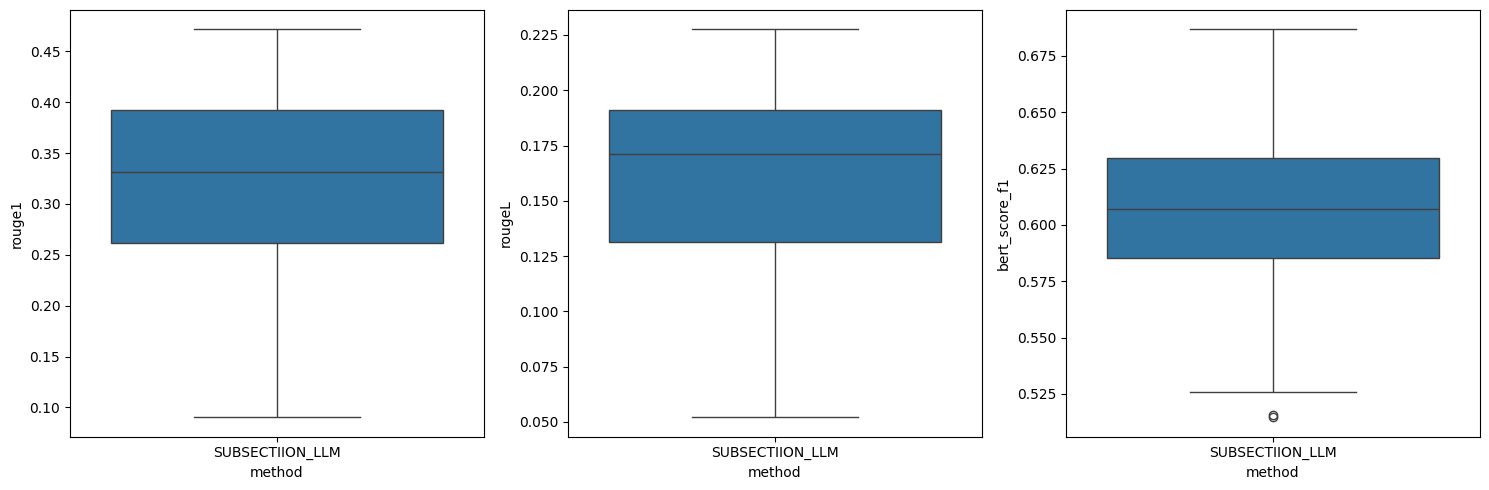

In [150]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=df_results, x="method", y="rouge1", ax=ax[0])
#sns.boxplot(data=df_results, x="method", y="rouge2", ax=ax[1])
sns.boxplot(data=df_results, x="method", y="rougeL", ax=ax[1])
sns.boxplot(data=df_results, x="method", y="bert_score_f1", ax=ax[2])
plt.tight_layout()

In [151]:
SUMMARIES_PATH

'../data/summaries'

In [160]:
print("I Implemented an llm based summarizer and want to understand what it is missing. Here are my summaries for 40 papers and their according abstracts used as a ground truth. Please tell me how i could improve my summarization:")

for summary_path in list(Path(SUMMARIES_PATH).iterdir())[:10]:
    summary  = open(summary_path/"summary.txt").read()
    print(summary)

    paper_id = summary_path.name

    abstract = open(Path(ABSTRACT_PATH)/f"{paper_id}.txt").read()
    print(abstract)

I Implemented an llm based summarizer and want to understand what it is missing. Here are my summaries for 40 papers and their according abstracts used as a ground truth. Please tell me how i could improve my summarization:
MTIR-SQL is a reinforcement learning framework for multi-turn tool-integrated reasoning in text-to-SQL, enhancing LLMs’ reasoning through trajectory filtering and KL regularization, resulting in improved SQL execution accuracy. Experiments on the BIRD dataset demonstrate its effectiveness, achieving a 16% absolute improvement over baselines. The methodology utilizes π θ ( ⋅ | x ; ℰ ) \pi_{\theta}(\cdot|x;\mathcal{E}) leveraging real-time execution results to guide the model’s reasoning. GRPO-Filter, an enhanced Group Relative Policy Optimization (GRPO) variant, incorporates three innovations: constrained optimization, selective rollout filtering, and multi-turn extension. Performance on main benchmarks is significantly higher than other models, with MTIR-SQL achievi